In [3]:
# Start loading libraries

#! pip install yfinance

# ! conda install seaborn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import scipy
import scipy.stats as stats
import statsmodels.api as sm

import scipy
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

import pmdarima as pm
from pmdarima import model_selection
from pmdarima.model_selection import SlidingWindowForecastCV

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error


from scipy.optimize import minimize
from random import gauss
import math
from statistics import mean, stdev

from numpy import asarray
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot


#! pip install tensorflow --user
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Input
from sklearn.preprocessing import MinMaxScaler

#from statsmodels.graphics.tsaplots import plot_acf

#from matplotlib.ticker import NullFormatter
#import yfinance as yf
#import warnings; warnings.simplefilter('ignore')
#%matplotlib inline

In [4]:
xls_file = pd.ExcelFile("Data_monthly_final.xlsx") # Read Excel
df1=xls_file.parse("Brent") # Read the first sheet (Portfolio holdings)

#df1["Timestamp"] = df1["Date"].astype('datetime64[ns]') # Convert column to date format
df1 = df1.set_index(['Timestamp']) # use first column as index

#df1.to_excel("values.xlsx")  #print to excel



In [5]:
spot = df1["LCOc1"]
spot = np.log(spot)
spot = spot.loc['2004-01-31':'2022-11-30']
spot_train = spot.loc[:'2016-07-31']
#spot_train.plot()

In [6]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
 #n_vars = 1 if type(data) is list else data.shape[1]
 df_temp = pd.DataFrame(data)
 cols = list()
 # input sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
    cols.append(df_temp.shift(i))
 # forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
    cols.append(df_temp.shift(-i))
 # put it all together
 agg = pd.concat(cols, axis=1)
 # drop rows with NaN values
 if dropnan:
    agg.dropna(inplace=True)
 return agg.values

In [7]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

In [9]:
# fix random seed for reproducibility
tf.random.set_seed(7)

# Load the data and split it into separate pieces
data = np.array(spot.dropna())
train, test = model_selection.train_test_split(data, train_size=(spot_train.shape[0]))

# normalize the dataset
scaler1 = MinMaxScaler(feature_range=(0, 1)).fit(train.reshape(-1, 1))  ### using only train data in the scaling
data_scaled = scaler1.transform(data.reshape(-1, 1))

time_lag = 12

batch_size = 1
epochs = 100

data_new = series_to_supervised(data_scaled, n_in=time_lag, n_out=1, dropnan=True)
#train, test = model_selection.train_test_split(data, train_size=(spot.shape[0]-1))

In [7]:
#data_scaled1 = scaler1.inverse_transform(data_scaled)
#np.exp(data_scaled1)

In [8]:
#train_new  = series_to_supervised(train, n_in=time_lag, n_out=1, dropnan=True)
#test_new = series_to_supervised(test, n_in=time_lag, n_out=1, dropnan=True)

In [12]:
# fit an lstm model and make a one step prediction
def lstm_forecast(trainlocal, testX):
 # transform list into array
 trainlocalar = asarray(trainlocal)
 # split into input and output columns
 trainX, trainy = trainlocalar[:, :-1], trainlocalar[:, -1]

 # reshape input to be [samples, time steps, features]
 trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
 testX = np.reshape(testX, (1, testX.shape[0], 1))  ### batch size 1 because model is recalibrated after avery step
 #testX = np.reshape(testX, (testX.shape[0], trainX.shape[1], 1))     #### PURKKARATKAISU ###

 # create and fit the LSTM network
 model = Sequential()
 #model.add(InputLayer((time_lag,1)))
 model.add(InputLayer((time_lag,1)))
 model.add(LSTM(150))
 #model.add(LSTM(4))
 #model.add(LSTM(4, input_shape=(1, time_lag), stateful = True))
 model.add(Dense(1))
 model.compile(loss='mean_squared_error', optimizer='adam')
 model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=2, shuffle=False)
 #model.fit(trainX, trainy, epochs=1, batch_size=1, verbose=2)
 
  # make a one-step prediction
 yhat = model.predict(testX)
 return yhat[0]

In [11]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
   predictions = list()
   # split dataset
   train1, test1 = train_test_split(data, n_test)
   # seed history with training dataset
   history = [x for x in train1]
   # step over each time-step in the test set
   for i in range(len(test1)):
      # split test row into input and output columns
      testX, testy = test1[i, :-1], test1[i, -1]
      # fit model on history and make a prediction
      yhat = lstm_forecast(history, testX)
      # store forecast in list of predictions
      predictions.append(yhat)
      # add actual observation to history for the next loop and delete oldest one
      history.append(test1[i])
      history.pop(0)
      # summarize progress
      print('>expected=%.1f, predicted=%.1f' % (testy, yhat))

    # estimate prediction error
   error = mean_absolute_error(test1[:, -1], predictions)
   return error, test1[:, -1], predictions 

  

In [13]:
# evaluate
mae, y, yhat = walk_forward_validation(data_new, len(test))
#mae, y, yhat = walk_forward_validation(data_new, 2)
print('MAE: %.3f' % mae)



Epoch 1/100
139/139 - 2s - loss: 0.0274 - 2s/epoch - 12ms/step
Epoch 2/100
139/139 - 0s - loss: 0.0226 - 466ms/epoch - 3ms/step
Epoch 3/100
139/139 - 0s - loss: 0.0240 - 472ms/epoch - 3ms/step
Epoch 4/100
139/139 - 0s - loss: 0.0234 - 480ms/epoch - 3ms/step
Epoch 5/100
139/139 - 0s - loss: 0.0206 - 472ms/epoch - 3ms/step
Epoch 6/100
139/139 - 0s - loss: 0.0176 - 472ms/epoch - 3ms/step
Epoch 7/100
139/139 - 0s - loss: 0.0156 - 466ms/epoch - 3ms/step
Epoch 8/100
139/139 - 0s - loss: 0.0136 - 438ms/epoch - 3ms/step
Epoch 9/100
139/139 - 0s - loss: 0.0120 - 451ms/epoch - 3ms/step
Epoch 10/100
139/139 - 0s - loss: 0.0107 - 458ms/epoch - 3ms/step
Epoch 11/100
139/139 - 0s - loss: 0.0094 - 450ms/epoch - 3ms/step
Epoch 12/100
139/139 - 0s - loss: 0.0085 - 483ms/epoch - 3ms/step
Epoch 13/100
139/139 - 0s - loss: 0.0076 - 434ms/epoch - 3ms/step
Epoch 14/100
139/139 - 0s - loss: 0.0069 - 456ms/epoch - 3ms/step
Epoch 15/100
139/139 - 0s - loss: 0.0063 - 434ms/epoch - 3ms/step
Epoch 16/100
139/139 

C:\Users\tatuh\AppData\Local\Temp\ipykernel_12068\3682001088.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('>expected=%.1f, predicted=%.1f' % (testy, yhat))


Epoch 1/100
139/139 - 3s - loss: 0.0244 - 3s/epoch - 20ms/step
Epoch 2/100
139/139 - 1s - loss: 0.0221 - 592ms/epoch - 4ms/step
Epoch 3/100
139/139 - 1s - loss: 0.0233 - 598ms/epoch - 4ms/step
Epoch 4/100
139/139 - 1s - loss: 0.0237 - 571ms/epoch - 4ms/step
Epoch 5/100
139/139 - 1s - loss: 0.0197 - 579ms/epoch - 4ms/step
Epoch 6/100
139/139 - 1s - loss: 0.0174 - 575ms/epoch - 4ms/step
Epoch 7/100
139/139 - 1s - loss: 0.0148 - 579ms/epoch - 4ms/step
Epoch 8/100
139/139 - 1s - loss: 0.0130 - 587ms/epoch - 4ms/step
Epoch 9/100
139/139 - 1s - loss: 0.0115 - 596ms/epoch - 4ms/step
Epoch 10/100
139/139 - 1s - loss: 0.0103 - 609ms/epoch - 4ms/step
Epoch 11/100
139/139 - 1s - loss: 0.0091 - 582ms/epoch - 4ms/step
Epoch 12/100
139/139 - 1s - loss: 0.0082 - 605ms/epoch - 4ms/step
Epoch 13/100
139/139 - 1s - loss: 0.0073 - 583ms/epoch - 4ms/step
Epoch 14/100
139/139 - 1s - loss: 0.0068 - 586ms/epoch - 4ms/step
Epoch 15/100
139/139 - 1s - loss: 0.0062 - 583ms/epoch - 4ms/step
Epoch 16/100
139/139 

In [14]:
y1 = scaler1.inverse_transform(y.reshape(-1, 1))
yhat1 = scaler1.inverse_transform(yhat)
#data_new1 = scaler1.inverse_transform(data_new)

In [15]:
#yhat1

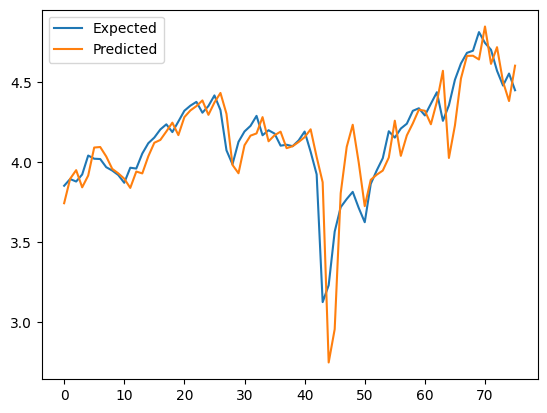

In [16]:
# plot expected vs predicted
pyplot.plot(y1, label='Expected')
pyplot.plot(yhat1, label='Predicted')
pyplot.legend()
pyplot.show()

In [17]:
def smape_kun(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true) / ((np.abs(y_pred) + np.abs(y_true))/2))*100

In [18]:
predictions = yhat1

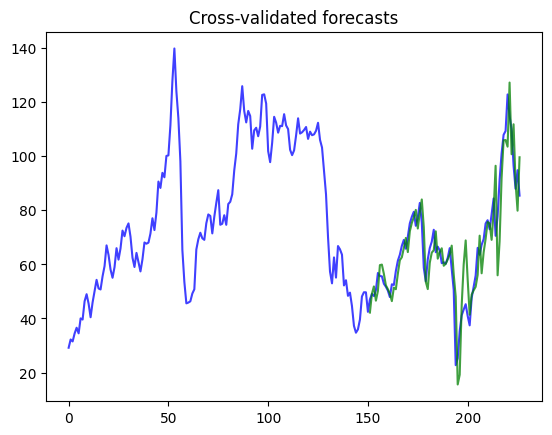

In [19]:
exp_predictions = np.exp(predictions)
exp_spot= np.exp(spot)
exp_test = np.exp(test)
exp_train = np.exp(train)

x_axis = np.arange(exp_spot.shape[0])
n_test = exp_predictions.shape[0]

plt.plot(x_axis, exp_spot, alpha=0.75, c='b')
plt.plot(x_axis[-n_test:], exp_predictions, alpha=0.75, c='g')  # Forecasts
plt.title("Cross-validated forecasts")
plt.show()

In [20]:
error = mean_squared_error(exp_test, exp_predictions)
print('Mean Squared Error: %.3f' % error)
error2 = mean_absolute_error(exp_test, exp_predictions)
print('Mean Absolute Error: %.3f' % error2)
error3 = mean_absolute_percentage_error(exp_test, exp_predictions)
print('Mean Absolute Percentage Error: %.3f' % (error3*100))
error4 = smape_kun(exp_test, exp_predictions)
print('Symmetric Mean Absolute Percentage Error: %.3f' % error4)

Mean Squared Error: 88.141
Mean Absolute Error: 6.948
Mean Absolute Percentage Error: 12.004
Symmetric Mean Absolute Percentage Error: 32.019


In [21]:
### same with built-in function ###

#predictions22 = model_selection.cross_val_score(
#    ar, spot, scoring='mean_absolute_error', cv=cv, verbose=0)
#np.average(predictions22)

In [22]:
#### MASE ###

abs_errors = abs(exp_predictions - exp_test)
mae_naive_list = []

for x in range(len(exp_test)):
    insample_data = exp_spot[x:-(len(exp_test)-x)]
    mae_insample = np.mean(abs(insample_data.diff().dropna()))
    mae_naive_list.append(mae_insample)

mase = np.mean(abs_errors / mae_naive_list)

print('Mean Absolute Scaled Error: %.3f' % mase)

Mean Absolute Scaled Error: 4.151


In [23]:
### Returns ###

returns = []

test_app2 = list(exp_test)
test_app2.insert(0, exp_train[-1]) ## append last of train data
price_moves = np.array(pd.DataFrame(test_app2).pct_change().dropna()+1)

pred_app2 = list(predictions)

test_shift2 = list(test)
test_shift2.insert(0, train[-1])
test_shift2.pop()

dir_pred2 = np.array(np.sign([a - b for a, b in zip(pred_app2,test_shift2)]))

for t in range(len(dir_pred2)):
    if dir_pred2[t] == 1:
            returns.append(price_moves[t])
        
    if dir_pred2[t] == -1:
        returns.append(1/price_moves[t])

returns = pd.DataFrame(returns)
returns


,0
0,0.902636
1,1.042942
2,0.984509
3,0.957004
4,0.888244
...,...
71,1.043632
72,0.877102
73,1.096976
74,0.927555


In [24]:
### Returns t-test ###

t_statistic, p_value = stats.ttest_1samp(a=returns, popmean=1, alternative='greater') ### one tailed test?


print(t_statistic , p_value)

[0.317269] [0.37596052]


In [25]:
### Merton test ###

test_app = list(test)
test_app.insert(0, train[-1]) ## append last of train data
dir = np.array(np.sign(pd.DataFrame(test_app).diff().dropna()))

pred_app = list(predictions)

test_shift = list(test)
test_shift.insert(0, train[-1])
test_shift.pop()

dir_pred = np.array(np.sign([a - b for a, b in zip(pred_app,test_shift)]))

q_minus = 0
q_plus = 0
pred_minus = 0
pred_plus = 0

for t in range(len(dir)):
    if dir[t] == 1:
        q_plus += 1
        if dir_pred[t] == 1:
            pred_plus += 1
    if dir[t] == -1:
        q_minus += 1
        if dir_pred[t] == -1:
            pred_minus += 1

print('Merton test: %.3f' % ((pred_plus / q_plus) + (pred_minus / q_minus)))

Merton test: 0.858


In [26]:
len(test)

76